In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split,TimeSeriesSplit,cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import metrics
from math import sqrt

trip=pd.read_csv('D:/Programming languages/Script/database/bikedata/trip_data.csv')
weather=pd.read_csv('D:/Programming languages/Script/database/bikedata/weather_data.csv')
station=pd.read_csv('D:/Programming languages/Script/database/bikedata/station_data.csv') 

In [2]:
trip.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


In [3]:
# slice the str for DataFrame
# process speed or memory usage is much more less

start,stop,step=0,-6,1
trip['Start Date']= trip['Start Date'].str.slice(start, stop, step)
trip['End Date']= trip['End Date'].str.slice(start, stop, step)

In [4]:
trip['Start Date']= pd.to_datetime(trip['Start Date'], dayfirst=True).dt.strftime('%Y/%m/%d')
trip['End Date']= pd.to_datetime(trip['End Date'], dayfirst=True).dt.strftime('%Y/%m/%d')

In [5]:
#remove two columns, default remove rows
trip=trip.drop(['Trip ID'],axis=1)

In [6]:
#convert from obj to datetime

trip['Count']='1'
trip['Count']=trip['Count'].astype('int64')
trip['Start Station']=trip['Start Station'].astype('str')
trip['End Station']=trip['End Station'].astype('str')
trip['Start Date']=pd.to_datetime(trip['Start Date'])
trip['End Date']=pd.to_datetime(trip['End Date'])

trip.dtypes

Start Date         datetime64[ns]
Start Station              object
End Date           datetime64[ns]
End Station                object
Subscriber Type            object
Count                       int64
dtype: object

In [7]:
# sort by Start Time
trip=trip.sort_values(by='Start Date', ascending=True)

In [8]:
trip.head()

,Start Date,Start Station,End Date,End Station,Subscriber Type,Count
354151,2014-09-01,66,2014-09-01,57,Customer,1
353900,2014-09-01,50,2014-09-01,77,Customer,1
353901,2014-09-01,50,2014-09-01,77,Customer,1
353902,2014-09-01,60,2014-09-01,47,Subscriber,1
353903,2014-09-01,65,2014-09-01,50,Customer,1


In [9]:
trip_demand=trip.drop(['End Date','End Station'],axis=1)
# sum only sum up type of column which is int
trip_demand=trip_demand.groupby(['Start Station','Start Date'], as_index=False).sum()

trip_supply=trip.drop(['Start Date','Start Station'],axis=1)
trip_supply=trip_supply.groupby(['End Station','End Date'], as_index=False).sum()
# without as_index=False, multiindex by using above function

In [10]:
# data types should be converted first(Start Station must be str, Start Date should be datetime64) 
# otherwise it could not be processed
trip_demand=trip_demand.groupby('Start Station').apply(lambda x : x.set_index('Start Date').resample('D').mean().fillna(0)).reset_index()

trip_supply=trip_supply.groupby('End Station').apply(lambda y : y.set_index('End Date').resample('D').mean().fillna(0)).reset_index()

In [11]:
trip_demand.head()

,Start Station,Start Date,Count
0,10,2014-09-02,11.0
1,10,2014-09-03,11.0
2,10,2014-09-04,5.0
3,10,2014-09-05,5.0
4,10,2014-09-06,2.0


In [12]:
# merge the two datasets, should use 'left' instead of 'outer'
comb=pd.merge(trip_demand,trip_supply,left_on=['Start Station', 'Start Date'],right_on=['End Station', 'End Date'],how='left')

# drop multiple columns
comb=comb.drop(['End Station', 'End Date'], axis=1)

In [13]:
# rename the columns
comb=comb.rename(columns={'Start Station': 'Station', 'Start Date': 'Date', 'Count_x':'trip_demand','Count_y':'trip_supply'})

# fill the NaN with 0
comb=comb.fillna(0)

# add gap column
comb['diff']=comb['trip_supply']-comb['trip_demand']

comb.head()

,Station,Date,trip_demand,trip_supply,diff
0,10,2014-09-02,11.0,6.0,-5.0
1,10,2014-09-03,11.0,8.0,-3.0
2,10,2014-09-04,5.0,4.0,-1.0
3,10,2014-09-05,5.0,4.0,-1.0
4,10,2014-09-06,2.0,2.0,0.0


In [14]:
station.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


In [15]:
station['Zip']='' # give it a blank to set up a column

In [16]:
for z in range(len(station)):
    if station['City'][z]=='San Jose': station['Zip'][z]='95113'
    if station['City'][z]=='San Francisco': station['Zip'][z]='94107'
    if station['City'][z]=='Redwood City': station['Zip'][z]='94063'
    if station['City'][z]=='Palo Alto': station['Zip'][z]='94301'
    if station['City'][z]=='Mountain View': station['Zip'][z]='94041'

D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Programming languages\anaconda

In [17]:
#combine trip and station datasets

station['Id']=station['Id'].astype('str')
terminal=pd.merge(comb,station,left_on='Station',right_on='Id',how='outer')
terminal['Zip']=terminal['Zip'].astype('str')

terminal=terminal.drop(['Id','Name'],axis=1)

In [18]:
terminal.head()

,Station,Date,trip_demand,trip_supply,diff,Lat,Long,Dock Count,City,Zip
0,10,2014-09-02,11.0,6.0,-5.0,37.337391,-121.886995,15,San Jose,95113
1,10,2014-09-03,11.0,8.0,-3.0,37.337391,-121.886995,15,San Jose,95113
2,10,2014-09-04,5.0,4.0,-1.0,37.337391,-121.886995,15,San Jose,95113
3,10,2014-09-05,5.0,4.0,-1.0,37.337391,-121.886995,15,San Jose,95113
4,10,2014-09-06,2.0,2.0,0.0,37.337391,-121.886995,15,San Jose,95113


In [19]:
weather['Date']= pd.to_datetime(weather['Date'], dayfirst=True).dt.strftime('%Y/%m/%d')
weather['Date']= pd.to_datetime(weather['Date'], dayfirst=True)
weather['Zip']=weather['Zip'].astype('str')

In [20]:
weather.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,2014-09-01,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,2014-09-02,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,2014-09-03,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,2014-09-04,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,2014-09-05,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


In [21]:
# merge the two datasets
daily_full=pd.merge(terminal,weather,on=['Date','Zip'],how='outer')

In [22]:
daily_full['event']=daily_full['Events']
daily_full['event'].loc[daily_full['event'].isnull()] = 'Clear'

D:\Programming languages\anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [23]:
daily_full['event_num']=daily_full['event']
event_num = {'Clear': 0,'Fog': 1, 'Fog-Rain':2, 'Rain':3,'Rain-Thunderstorm':4 } 
daily_full.event_num = [event_num[item] for item in daily_full.event_num]

In [24]:
daily_full=daily_full.drop(['Events','event'],axis=1)

In [25]:
# check how many unique values in a column

daily_full.event_num.unique()

array([0, 3, 1, 2, 4], dtype=int64)

In [26]:
daily_full[daily_full.iloc[:,10:30].isnull().values==True]

,Station,Date,trip_demand,trip_supply,diff,Lat,Long,Dock Count,City,Zip,...,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,event_num
1424,10,2014-11-30,0.0,0.0,0.0,37.337391,-121.886995,15.0,San Jose,95113,...,10.0,8.0,2.0,9.0,6.0,NaN,0.57,5.0,128.0,3
1425,11,2014-11-30,0.0,0.0,0.0,37.335885,-121.885660,19.0,San Jose,95113,...,10.0,8.0,2.0,9.0,6.0,NaN,0.57,5.0,128.0,3
1426,12,2014-11-30,0.0,0.0,0.0,37.332808,-121.883891,19.0,San Jose,95113,...,10.0,8.0,2.0,9.0,6.0,NaN,0.57,5.0,128.0,3
1427,13,2014-11-30,0.0,0.0,0.0,37.339301,-121.889937,15.0,San Jose,95113,...,10.0,8.0,2.0,9.0,6.0,NaN,0.57,5.0,128.0,3
1428,14,2014-11-30,0.0,0.0,0.0,37.332692,-121.900084,19.0,San Jose,95113,...,10.0,8.0,2.0,9.0,6.0,NaN,0.57,5.0,128.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22782,82,2015-06-16,27.0,29.0,2.0,37.798541,-122.400862,15.0,San Francisco,94107,...,10.0,9.0,5.0,20.0,12.0,NaN,0.00,5.0,254.0,0
22783,87,2015-06-16,25.0,28.0,3.0,37.790302,-122.390637,19.0,San Francisco,94107,...,10.0,9.0,5.0,20.0,12.0,NaN,0.00,5.0,254.0,0
22784,88,2015-06-16,114.0,142.0,28.0,37.776600,-122.395470,23.0,San Francisco,94107,...,10.0,9.0,5.0,20.0,12.0,NaN,0.00,5.0,254.0,0
22785,90,2015-06-16,23.0,24.0,1.0,37.781039,-122.411748,23.0,San Francisco,94107,...,10.0,9.0,5.0,20.0,12.0,NaN,0.00,5.0,254.0,0


In [27]:
daily_full.iloc[:,9:35]=daily_full.iloc[:,9:35].fillna(daily_full.iloc[:,9:30].mean())

In [28]:
daily_full[daily_full.isnull().values==True]

,Station,Date,trip_demand,trip_supply,diff,Lat,Long,Dock Count,City,Zip,...,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,event_num
12547,34,2015-08-08,3.0,1.0,-2.0,37.443988,-122.164759,23.0,Palo Alto,94301,...,10.157973,9.511171,7.755605,16.970796,6.734612,22.12887,0.033573,3.568194,NaN,0
12548,35,2015-08-08,8.0,7.0,-1.0,37.444521,-122.163093,11.0,Palo Alto,94301,...,10.157973,9.511171,7.755605,16.970796,6.734612,22.12887,0.033573,3.568194,NaN,0
12549,36,2015-08-08,1.0,4.0,3.0,37.429082,-122.142805,15.0,Palo Alto,94301,...,10.157973,9.511171,7.755605,16.970796,6.734612,22.12887,0.033573,3.568194,NaN,0
12550,37,2015-08-08,2.0,2.0,0.0,37.448598,-122.159504,11.0,Palo Alto,94301,...,10.157973,9.511171,7.755605,16.970796,6.734612,22.12887,0.033573,3.568194,NaN,0
12551,38,2015-08-08,0.0,0.0,0.0,37.425684,-122.137777,15.0,Palo Alto,94301,...,10.157973,9.511171,7.755605,16.970796,6.734612,22.12887,0.033573,3.568194,NaN,0
25446,NaN,2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94063,...,10.000000,10.000000,10.000000,12.000000,2.000000,22.12887,0.000000,0.000000,339.0,0
25446,NaN,2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94063,...,10.000000,10.000000,10.000000,12.000000,2.000000,22.12887,0.000000,0.000000,339.0,0
25446,NaN,2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94063,...,10.000000,10.000000,10.000000,12.000000,2.000000,22.12887,0.000000,0.000000,339.0,0
25446,NaN,2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94063,...,10.000000,10.000000,10.000000,12.000000,2.000000,22.12887,0.000000,0.000000,339.0,0
25446,NaN,2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94063,...,10.000000,10.000000,10.000000,12.000000,2.000000,22.12887,0.000000,0.000000,339.0,0


In [29]:
daily_full=daily_full.dropna()

In [30]:
daily_full['Station']=daily_full['Station'].astype('int64')
daily_full['Zip']=daily_full['Zip'].astype('int64')

In [31]:
#####################################City

In [32]:
daily_full=daily_full.groupby(['City','Date'], as_index=False).sum()

In [33]:
# add week day column
daily_full['Week day'] = daily_full['Date'].dt.day_name()
cats = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
daily_full['Week day']=daily_full['Week day'].astype('category')
daily_full['Week day'].cat.set_categories(cats, inplace=True)
daily_full.dtypes

City                                 object
Date                         datetime64[ns]
Station                               int64
trip_demand                         float64
trip_supply                         float64
diff                                float64
Lat                                 float64
Long                                float64
Dock Count                          float64
Zip                                   int64
Max TemperatureF                    float64
Mean TemperatureF                   float64
Min TemperatureF                    float64
Max Dew PointF                      float64
MeanDew PointF                      float64
Min DewpointF                       float64
Max Humidity                        float64
Mean Humidity                       float64
Min Humidity                        float64
Max Sea Level PressureIn            float64
Mean Sea Level PressureIn           float64
Min Sea Level PressureIn            float64
Max VisibilityMiles             

In [34]:
correlation=daily_full.corr()
print(correlation['diff'].sort_values(ascending=False))

diff                         1.000000
Max Gust SpeedMPH            0.016217
Max VisibilityMiles          0.012609
Mean Wind SpeedMPH           0.011069
Min Sea Level PressureIn     0.009833
Mean Sea Level PressureIn    0.009792
Max Sea Level PressureIn     0.009683
Max TemperatureF             0.009566
Min VisibilityMiles          0.009542
Zip                          0.009446
Lat                          0.009414
Station                      0.008872
Dock Count                   0.008771
Mean VisibilityMiles         0.008358
Mean TemperatureF            0.008183
Max Humidity                 0.007062
CloudCover                   0.006798
Min TemperatureF             0.006336
WindDirDegrees               0.005566
trip_supply                  0.004813
MeanDew PointF               0.004100
Max Dew PointF               0.004081
Min DewpointF                0.003960
Mean Humidity                0.002494
trip_demand                  0.001002
Max Wind SpeedMPH           -0.002122
Min Humidity

In [35]:
daily_full.City.unique()

array(['Mountain View', 'Palo Alto', 'Redwood City', 'San Francisco',
       'San Jose'], dtype=object)

In [36]:
City=str(input('Enter the City'))

Enter the CitySan Francisco


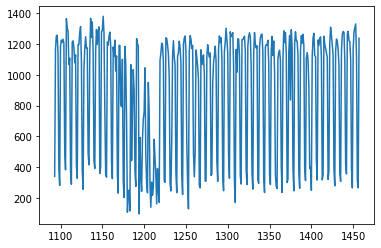

In [37]:
# use input station no at first

# attention to the data type for input

if str(City) in daily_full.City.unique(): 
    # use iloc or loc to select the requested data from dataset, like SQL
    daily_seg = daily_full.loc[daily_full['City'] == City]
    # plot for this station
    plt.plot(daily_seg['trip_demand'])
else:
    print('Invalid input. Try again!')

In [38]:
daily_seg = pd.get_dummies(daily_seg)
daily_seg.head()

,Date,Station,trip_demand,trip_supply,diff,Lat,Long,Dock Count,Zip,Max TemperatureF,...,WindDirDegrees,event_num,City_San Francisco,Week day_Monday,Week day_Tuesday,Week day_Wednesday,Week day_Thursday,Week day_Friday,Week day_Saturday,Week day_Sunday
1093,2014-09-01,2112,340.0,336.0,-4.0,1322.569539,-4284.054505,665.0,3293745,2905.0,...,10150.0,0,1,1,0,0,0,0,0,0
1094,2014-09-02,2112,1170.0,1171.0,1.0,1322.569539,-4284.054505,665.0,3293745,2520.0,...,10150.0,0,1,0,1,0,0,0,0,0
1095,2014-09-03,2112,1253.0,1255.0,2.0,1322.569539,-4284.054505,665.0,3293745,2660.0,...,9660.0,0,1,0,0,1,0,0,0,0
1096,2014-09-04,2112,1258.0,1255.0,-3.0,1322.569539,-4284.054505,665.0,3293745,2590.0,...,10535.0,0,1,0,0,0,1,0,0,0
1097,2014-09-05,2112,1145.0,1144.0,-1.0,1322.569539,-4284.054505,665.0,3293745,2520.0,...,10815.0,0,1,0,0,0,0,1,0,0


In [39]:
print(daily_seg['trip_demand'].mean(),daily_seg['trip_demand'].std())

879.7397260273973 411.59520907960945


In [40]:
y=daily_seg['trip_demand']


#drop trip_in and trip_out to avoid invalid prediction
x=daily_seg.drop(['diff','Date','trip_demand','trip_supply'],axis=1)

In [41]:
from sklearn import preprocessing

x=np.array(x)
y=np.array(y)

#hyper parameter tunning
rate=0.75

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=rate,random_state=1)

In [42]:
# regression methodologies

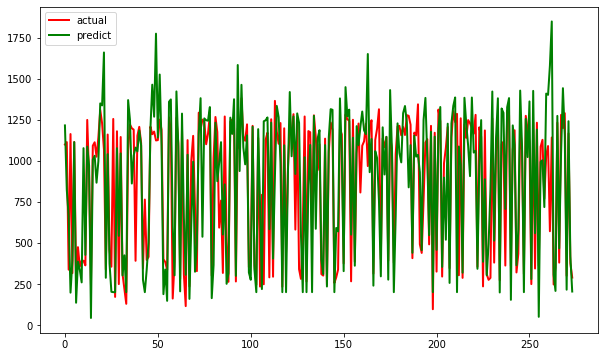

lr_r2= 0.5570620943857185
lr_mae= 188.47265267896128
lr_mse= 74610.13676546195
lr_rmse= 273.14856171223374


In [60]:
#linear regression

lr=LinearRegression()
lr.fit(x_train,y_train)

y_hat=lr.predict(x_test)
y_hat[y_hat<0]=200

plt.figure(figsize=(10,6))
t=np.arange(len(x_test))

plt.plot(t,y_test,'r',linewidth=2,label='actual')
plt.plot(t,y_hat,'g',linewidth=2,label='predict')
plt.legend()
plt.show()

from sklearn.metrics import r2_score

print('lr_r2=',r2_score(y_test,y_hat))
print('lr_mae=',metrics.mean_absolute_error(y_test,y_hat))
print('lr_mse=',metrics.mean_squared_error(y_test,y_hat))
print('lr_rmse=',np.sqrt(metrics.mean_squared_error(y_test,y_hat)))

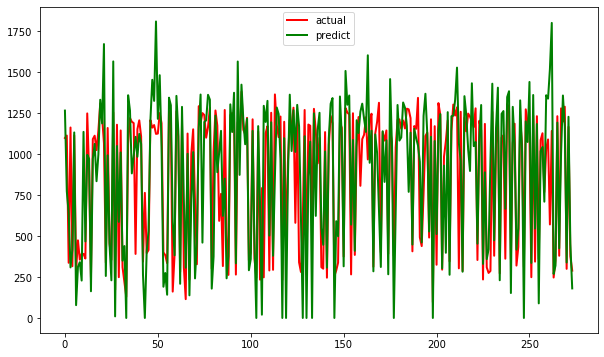

ridge_r2= 0.5589473116193604
ridge_mae= 195.33416812566364
ridge_mse= 74292.58364153242
ridge_rmse= 272.56665907908183


In [63]:
#Ridge Regression

ridge=Ridge(alpha=0.01)
ridge.fit(x_train,y_train)

y_hat=ridge.predict(x_test)
y_hat[y_hat<0]=0
plt.figure(figsize=(10,6))
t=np.arange(len(x_test))

plt.plot(t,y_test,'r',linewidth=2,label='actual')
plt.plot(t,y_hat,'g',linewidth=2,label='predict')
plt.legend()
plt.show()

ridge.score(x_test,y_test)
print('ridge_r2=',metrics.r2_score(y_test,y_hat))
print('ridge_mae=',metrics.mean_absolute_error(y_test,y_hat))
print('ridge_mse=',metrics.mean_squared_error(y_test,y_hat))
print('ridge_rmse=',np.sqrt(metrics.mean_squared_error(y_test,y_hat)))

D:\Programming languages\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392033.4711662, tolerance: 1532.1551032967034
  positive)


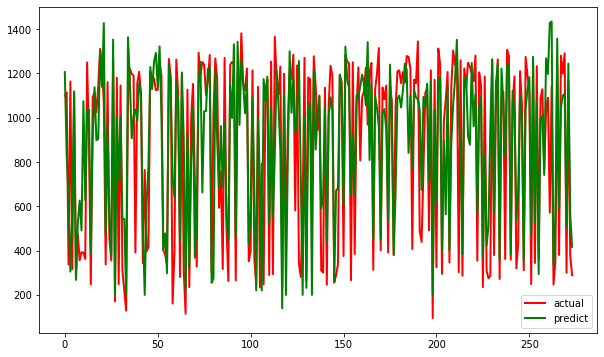

Lasso_r2= 0.6270492960412273
Lasso_mae= 184.81597561951392
Lasso_mse= 62821.227708090235
Lasso_rmse= 250.64163203284932


In [65]:
#Lasso Regression

lasso=Lasso(alpha=18)
lasso.fit(x_train,y_train)

y_hat=lasso.predict(x_test)
y_hat[y_hat<0]=200
plt.figure(figsize=(10,6))
t=np.arange(len(x_test))

plt.plot(t,y_test,'r',linewidth=2,label='actual')
plt.plot(t,y_hat,'g',linewidth=2,label='predict')
plt.legend()
plt.show()

print('Lasso_r2=',metrics.r2_score(y_test,y_hat))
print('Lasso_mae=',metrics.mean_absolute_error(y_test,y_hat))
print('Lasso_mse=',metrics.mean_squared_error(y_test,y_hat))
print('Lasso_rmse=',np.sqrt(metrics.mean_squared_error(y_test,y_hat)))

D:\Programming languages\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


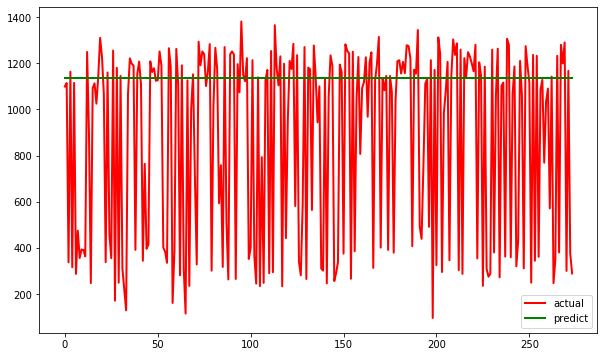

svr_r2= -0.4373486292507873
svr_mae= 343.0839416058394
svr_mse= 242112.4416058394
svr_rmse= 492.04922681154517


In [46]:
#svm
# kernel=‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’;default is rbf

from sklearn.svm import SVR

linear_svr=SVR(kernel='rbf', C=0.2)
linear_svr.fit(x_train,y_train)
y_hat=linear_svr.predict(x_test)


plt.figure(figsize=(10,6))
t=np.arange(len(x_test))

plt.plot(t,y_test,'r',linewidth=2,label='actual')
plt.plot(t,y_hat,'g',linewidth=2,label='predict')
plt.legend()
plt.show()

print('svr_r2=',metrics.r2_score(y_test,y_hat))
print('svr_mae=',metrics.mean_absolute_error(y_test,y_hat))
print('svr_mse=',metrics.mean_squared_error(y_test,y_hat))
print('svr_rmse=',np.sqrt(metrics.mean_squared_error(y_test,y_hat)))

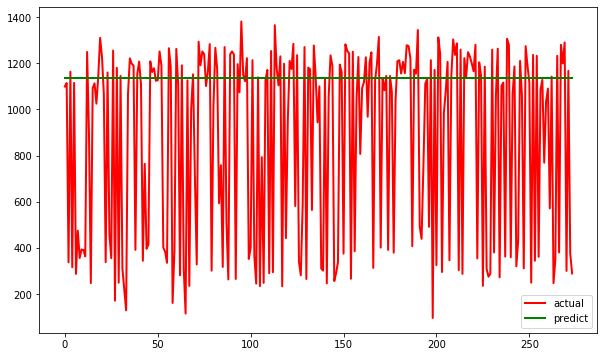

RFR_r2= -0.4373486292507873
RFR_mae= 343.0839416058394
RFR_mse= 242112.4416058394
RFR_rmse= 492.04922681154517


In [47]:
#random forecast
#can not draw trend plot, everytime is random number

from sklearn.ensemble import RandomForestRegressor as RFR

rf=RFR(n_estimators=10,max_depth=None)
rf.fit(x_train,y_train)

y_hat_RFR=rf.predict(x_test)

plt.figure(figsize=(10,6))
t=np.arange(len(x_test))

plt.plot(t,y_test,'r',linewidth=2,label='actual')
plt.plot(t,y_hat,'g',linewidth=2,label='predict')
plt.legend()
plt.show()

print('RFR_r2=',metrics.r2_score(y_test,y_hat))
print('RFR_mae=',metrics.mean_absolute_error(y_test,y_hat))
print('RFR_mse=',metrics.mean_squared_error(y_test,y_hat))
print('RFR_rmse=',np.sqrt(metrics.mean_squared_error(y_test,y_hat)))

D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
D:\Programming languages\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
D:\Programming languages\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1186984.6994800153, tolerance: 1532.1551032967034
  positive)
D:\Programming languages\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1244502.9926066222, tolerance: 1532.1551032967034
  positive)
D:\Programming langu

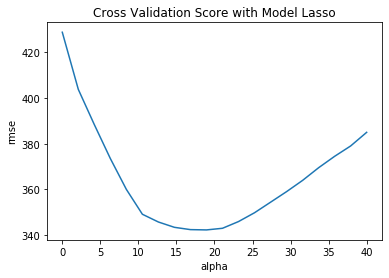

In [48]:
#Lasso

alphas_lasso=np.linspace(0,40,20)
rmse_lasso=[]
for alpha in alphas_lasso:
    model=Lasso(alpha)
    model.fit(x_train,y_train)
    y_hat_lasso=model.predict(x_test)
    rmse_lasso.append(np.sqrt(metrics.mean_squared_error(y_test,y_hat_lasso)))

plt.plot(alphas_lasso,rmse_lasso)
plt.title('Cross Validation Score with Model Lasso')
plt.xlabel('alpha')
plt.ylabel('rmse')
plt.show()

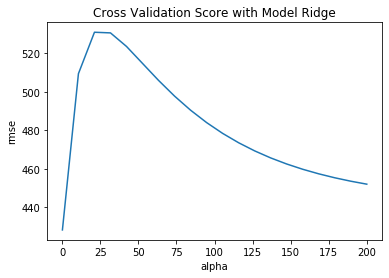

In [49]:
#Ridge

alphas_ridge=np.linspace(0.1,200,20)
rmse_ridge=[]
for alpha in alphas_ridge:
    model=Ridge(alpha)
    model.fit(x_train,y_train)
    y_hat_ridge=model.predict(x_test)
    rmse_ridge.append(np.sqrt(metrics.mean_squared_error(y_test,y_hat_ridge)))

plt.plot(alphas_ridge,rmse_ridge)
plt.title('Cross Validation Score with Model Ridge')
plt.xlabel('alpha')
plt.ylabel('rmse')
plt.show()

In [67]:
# final model with prediction
#lasso

print(y_hat.astype(int))

[1205  831  645  304  557 1118  267  523  625  490 1074  626 1033 1036
  389  905 1136  897  903 1297 1138 1426  475  967  528  379 1352  202
 1000  718 1004  544  542  200 1363 1172  907 1009 1037  984 1156 1109
  500  200  613  778 1228 1128 1250 1291 1140 1321 1010  402  477  298
 1237 1154  725  640 1158 1067  443 1203  910  222  926  324  808 1043
  367  568 1156 1251  662 1028 1030 1220 1226  254  273 1210  897  683
  961  687  975  552  447 1148  998 1331  463 1342  966 1258 1152 1019
 1159  428  574 1090  675  220  994  701  219 1174 1074 1184  518 1042
  553  826 1211 1056  850  139 1102  200  804 1299 1022 1181  930 1011
 1255  713  200 1001  231 1000 1069  200 1214  855 1009 1093  588  643
 1045  439 1005 1091 1026  265  670  682 1191 1121  605 1320 1167 1133
  650  920  650 1100 1095 1141 1194 1154 1055 1341  808 1153  456 1101
 1043  961  449 1021 1038  944  537 1239  965  382  663 1085 1099 1045
 1126 1243 1215  840 1098  767 1124 1091 1082 1033  673 1093 1050 1153
  711 